In [58]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
#!{sys.executable} -m nltk.download('stopwords')
#!{sys.executable} -m nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Reading the files
All data which is gathered for the training of the model is kept at place. First, we have to read all the data from the specified path and can store in python so it can be used whenever it is required.

In [2]:
path1 = "C:/College/01_Subjects/sem2/machine_learning/assignment/enron1/spam/"
path2 = "C:/College/01_Subjects/sem2/machine_learning/assignment/enron1/ham/"

Mails are categorized into two category ham and spam. We are saving mails (spam) in files1 and mails(ham) in files2 as a list. These lists are then converted into a data frame and merged together.

In [3]:
files1 = []
for i in os.listdir(path1):
    with open(path1 +i, 'r',encoding="utf8", errors='ignore') as myfile:
        #print(myfile)
        files1.append(myfile.read())

files2 = []
for i in os.listdir(path2):
    with open(path2 +i, 'r',encoding="utf8",errors='ignore') as myfile:
        #print(myfile)
        files2.append(myfile.read())
        

There are some duplicate emails which are present in data, these mail can manipulate the accuracy of the model. It is always better to remove duplicacy from the data.

In [39]:
import warnings
warnings.filterwarnings('ignore')

df1 = pd.DataFrame(files1, columns=['mails'])
df_s = df1.drop_duplicates(subset = ["mails"], keep = "first")
df_s['type'] = 0 #spam
df_s = df_s.reset_index()

df2 = pd.DataFrame(files2, columns=['mails'])
df_h = df2.drop_duplicates(subset = ["mails"], keep = "first")
df_h['type'] = 1 #ham
df_h = df_h.reset_index()

df = pd.concat([df_s, df_h], axis=0, ignore_index= True)
df.head(5)

,index,mails,type
0,0,Subject: dobmeos with hgh my energy level has ...,0
1,1,Subject: your prescription is ready . . oxwq s...,0
2,2,Subject: get that new car 8434\npeople nowthe ...,0
3,3,"Subject: await your response\ndear partner ,\n...",0
4,4,"Subject: coca cola , mbna america , nascar par...",0


## Bag Of Words (Corpus)
In NLP (natural language processing) all words are considered as features and weight can be assigned to feature according to different methods like their count of each word or using tf-idf. First of all, we need to find important features from the available data, which is called data cleaning. Data cleaning can be a break in different steps. First of all for this project we are taking each mail and selecting only words that contain only alphabets. Words with upper and lower cases should be considered the same, so we have converted all words in lower case. We have seen that the stopwords are not important for our model to provide insights into data and yet it add complexity to the model, so it is better to remove these words from data. After all this, we have done stemming of the words to reduce the feature, words which contribute the same information to data, so it is better to consider those words the same. After all, these all pre-processed words are stored in a corpus which will be used to train the model later.

In [5]:
corpus = []
for i in range(0, len(df)):
    mail = re.sub('[^a-zA-Z]', ' ', str(df['mails'][i]))
    mail = mail.lower()
    mail = mail.split()
    # Init the Wordnet Lemmatizer, porterstemmer
    ps = PorterStemmer() 
    lem = WordNetLemmatizer()
    mail = [ps.stem(lem.lemmatize(word)) for word in mail if not word in (set(stopwords.words('english')))]
    mail = [word for word in mail if len(word) >3]
    mail = ' '.join(mail)
    corpus.append(mail)

## EDA (Exploratory Data Analysis)
It is always a good choice to understand your data fully. We should know the list of the word present in data. To understand this we can plot a graph for different words present in ham and spam emails. We are making a function that can draw the wordcloud for its function.

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        #background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

Here, by using function <code>show_wordcloud </code> we are ploting for spam words.

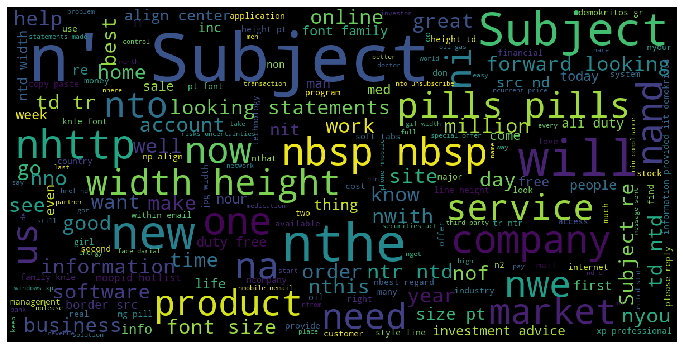

In [7]:
show_wordcloud(files1)

As we can see from the wordcloud subject, company, pills, etc are some common words present in spam mails.<br> The same function can be used to get wordcloud of words present in ham type of mails.

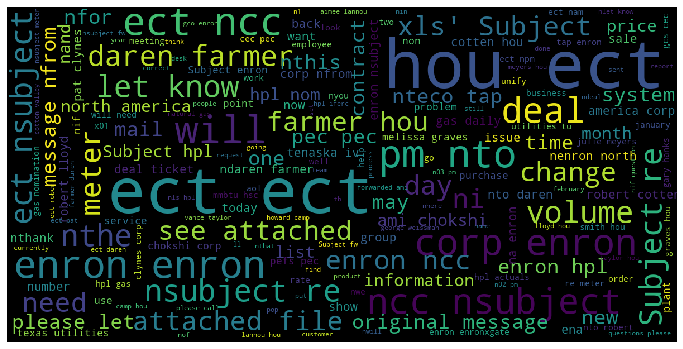

In [8]:
show_wordcloud(files2)

We cannot apply machine learning model to the text data, so its better to convert text into numbers to perform the exploratory data analysis.<br>
The CountVectorizer gives a basic method to both tokenize an assortment of text documents and assemble a vocabulary of known words, yet additionally to encode new documents utilizing that vocabulary.

We can directly check for the count of the ham and spam mails count present in the dataset. It is always helpful to see how different classes are distributed among all the labels.

Text(0.5, 1.0, 'Distribution of Spam and Ham')

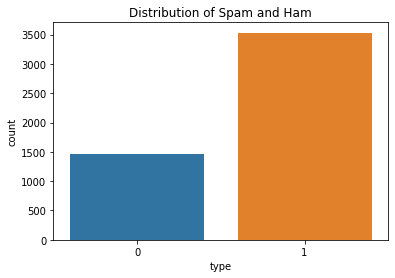

In [55]:
import seaborn as sns

sns.countplot(x = "type", data = df)
df.loc[:, 'type'].value_counts()
plt.title('Distribution of Spam and Ham')

Here we are also interested to have the insight of each mail, the length distribution of each mail on ham or spam can be checked by drawing a density curve. 

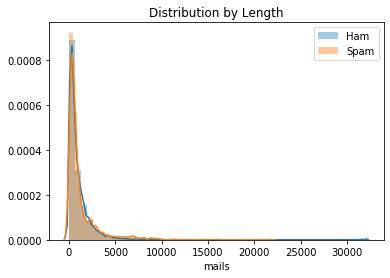

In [56]:
ham =df[df['type'] == 1]['mails'].str.len()
sns.distplot(ham, label='Ham')
spam = df[df['type'] == 0]['mails'].str.len()
sns.distplot(spam, label='Spam')
plt.title('Distribution by Length')
plt.legend()

In [9]:
# Creating the Bag of Words model 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer(max_features = 20)
X2 = cv.fit_transform(corpus)
Max_count = cv.vocabulary_
name_max_count = cv.get_feature_names()


The above max features value is set to 20, used in the Countvectorizer. As it is self-explanatory this parameter is used to get 20 most occurred features. A plot can be used to see the frequencies of these words.

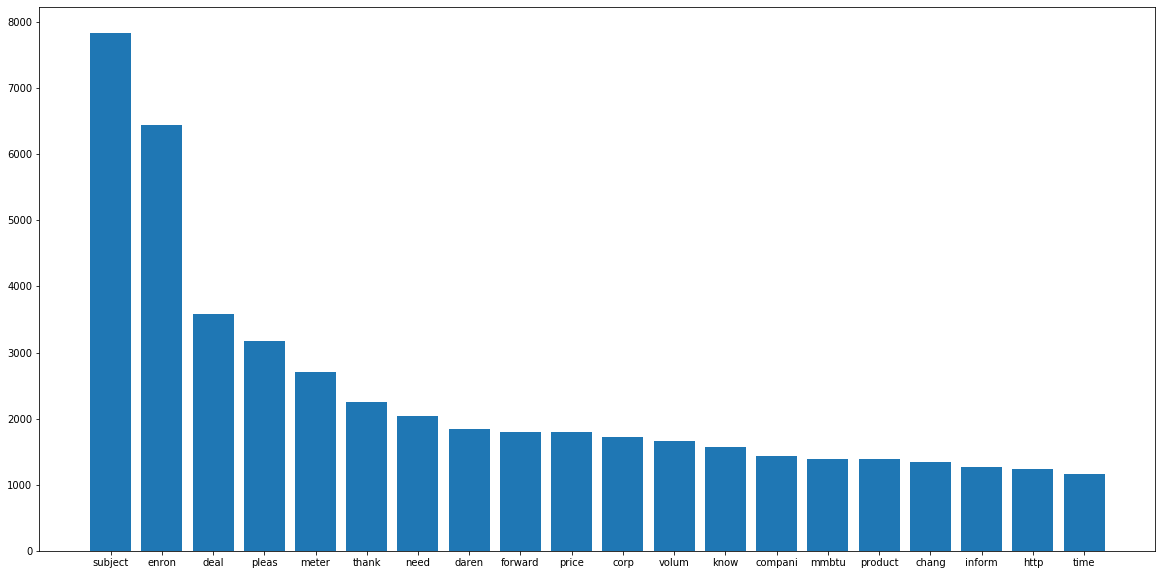

In [10]:
freqs = zip(cv.get_feature_names(), X2.sum(axis=0).tolist()[0])    
# sort from largest to smallest
Max_count = sorted(freqs, key=lambda x: -x[1])

plt.subplots(1, figsize=(20,10))
plt.bar(*zip(*Max_count))
plt.show()

Here, "Subject" is the most occurred word in almost every mail, and time is at 20th rank in this list.

### Tf-Idf (Term frequency and Inverse document frequency)

TF-IDF (Term Frequency and Inverse document frequency) is a factual measure that assesses how important a word in a document. This is done by in two steps: how frequently a word shows up in a record, and the inverse recurrence of the word over a no. of documents. Max feature is a parameter that is used to select most occurred features among all the feature from all available.<br> <br>__*TF(t)*__ = _(Number of times term t appears in a document) / (Total number of terms in the document)_. <br>__*IDF(t)*__ = _log_e(Total number of documents / Number of documents with term t in it)_.<br><br>We have selected 550 max features from the available corpus and assigned it to the features as "X". Its type is stored as label "y". Now we have 4994 rows of data each has 550 features.


In [11]:

# Using Tf-idf Method
tfidf = TfidfVectorizer(max_features = 550)
X = tfidf.fit_transform(corpus).toarray()
vocab = tfidf.vocabulary_
y = df["type"]


### Train-Test Split

It is suggested already that data is to be divided into 70-30 ratio for train test data. Here we are using <code> train_test_split </code> function from <code> sklearn.model_selection </code> library and test size is fixed to 0.30. 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 52)

### Model Selection

After dividing the data, we came across the main step which is deciding the model. We will try Naive Bayes for fitting the data for now. An object with name <code>classifier</code> of Gaussian Naive Bayes is created and training features and labels are feed into the model for training. Naive Bayes classifier is a model that depends on the probability of the events. It uses Bayes theorem to get the probability of the occurrence. For more details we can follow the given link <a> https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c</a>

In [13]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
#classifier.theta_

GaussianNB(priors=None, var_smoothing=1e-09)

After training the model we can feed any testing data to check the accuracy of the model how good our model is working.

In [14]:
# Predicting the Test set results
y_pred_G = classifier.predict(X_test)

<code>y_pred_G</code> here is the predicted value of test features <code>X_test</code> 

### Model Evaluation

Now we have predicted values that can be compared with the actual testing labels and can check how good our model is performing. However there are many methods that can be used to check model performance, some of them are confusion matrics, the accuracy of the model and the ROC-AUC curve.

In [15]:
# Evaluation of model
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve
cm1 = confusion_matrix(y_test, y_pred_G)
ac1 = accuracy_score(y_test, y_pred_G)
roc1 = roc_auc_score(y_test, y_pred_G)

In [16]:
print("accuracy: ", ac1)

accuracy:  0.9392928619079386


accuracy of the model is 0.9392. This accuracy is measured on a testing dataset which means our model is 93.9% accurate in identifying ham/spam mails with an unknown dataset.

In [17]:
print("Confusion Matric: \n",cm1)

Confusion Matric: 
 [[439  19]
 [ 72 969]]


As it is clear from the confusion matrix, there are 439 spam and the same 969 ham mails which are classified correctly. However, 19 spam mails are labeled as ham and 72 mails which are used to be ham but marked spam at the same time 

In [18]:
print("classification report: \n", classification_report(y_test, y_pred_G))

classification report: 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       458
           1       0.98      0.93      0.96      1041

    accuracy                           0.94      1499
   macro avg       0.92      0.94      0.93      1499
weighted avg       0.94      0.94      0.94      1499



## Comparing Algorithms

The way in to a reasonable examination of AI algorithms is guaranteeing that every algorithm is assessed similarly on similar information. <br>
You can accomplish this by constraining every algorithm to be assessed on a steady test bridle. <br>
In the given situation 6 unique algorithms are looked at:<br>
<ol>
<li>Logistic Regression</li>
<li>Linear Discriminant Analysis</li>
<li>K-Nearest Neighbors</li>
<li>Classification and Regression Trees</li>
<li>Naive Bayes</li>
<li>Support Vector Machines</li>
</ol>
    
The 10-fold cross-validation method is utilized to assess every algorithm, critically arranged with a similar random seed to guarantee that similar parts to the training data are performed and that every algorithm is assessed in exactly a similar way. <br>
Every algorithm is given a short name, valuable for condensing results a while later.

In [24]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import sys
!{sys.executable} -m pip install PrettyTable
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

# prepare configuration for cross validation test harness
seed = 52
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='scale')))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
t = PrettyTable(['Name', 'Accuracy','std. deviation'])
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    t.add_row([name, cv_results.mean(),cv_results.std()]) 
print(t)

+------+--------------------+----------------------+
| Name |      Accuracy      |    std. deviation    |
+------+--------------------+----------------------+
|  LR  | 0.953934506753991  | 0.013683430459142625 |
| LDA  | 0.9473573475235366 | 0.012593174161118948 |
| KNN  | 0.9404854686860418 | 0.007977465724888727 |
| CART | 0.9330503479328695 | 0.012593797036865374 |
|  NB  | 0.9442144903806795 | 0.011911200829941248 |
| SVM  | 0.9625198526401965 | 0.009931723204658552 |
+------+--------------------+----------------------+


The above results are showing the name of the algorithm used for classification with mean accuracy and the standard deviation associated with the accuracy.

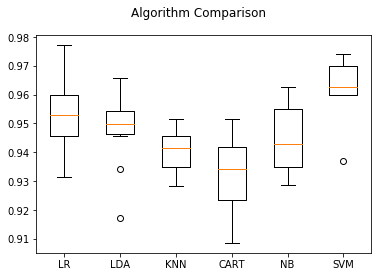

In [47]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

All algorithms are compared and a boxplot is also drawn to compare the accuracy and its deviation. __*Support Vector Machine*__ has the highest accuracy whereas __*CART*__ is showing the lowest.<br> One thing which is to be noticed here is although __SVM__ has the highest accuracy, it has outliers also which means the model is not stable. Keeping all in mind we can say __LR__ and __NB__ are performing well on this particular data set (both are stable as well as good accuracy).

# ROC Curve

Models can also be compared based on their ROC curves. ROC (receiver operating characteristic curve) illustrates the ability of the model by its graphical area. Two best models from above can be checked using the ROC curve how they are performing. Here <code>Logistic Regression</code> and <code>naive Bayes</code> algorithm are compared.

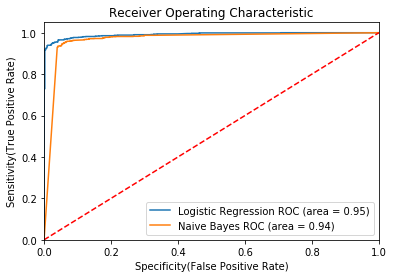

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Naive Bayes',
    'model': GaussianNB() ,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

As we can see above in ROC curve, <code>Logistic Regression</code> has covered area of <code>95%</code> whereas <code>Naive Bayes</code> has <code>94%</code> of area, which is self explanatory that Logistic Regression is performing better than Naive Bayes.

# Dumping Model
As we know the algorithm takes time to run, and it becomes more time consuming when we deal with a large dataset with multiple algorithms. In this situation, we cannot afford to run algorithms again and again. It's better to save the model parameters once so it can be used directly for next time. <code>pickle</code> is the library that helps us to the same model parameters to the disk. In this way, we can dump the model parameters into the system disk and can use it for future computation.

In [125]:
import pickle

# save the model to disk
model_dump_file = 'finalized_model.sav'
pickle.dump(classifier, open(model_dump_file, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(model_dump_file, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9392928619079386


This is the same accuracy that we achieved before, but this time without running the algorithm.

__Report by -__<br>
Sandeep Sharma

__Guided by -__<br>
Haithem Afli<br>
( _Invistigator at ADAPT Centre_ )